# Calorie Estimator

A multimodal regression model combining image, text, and a numeric feature (dish total mass) to predict a continuous target value. Evaluation metric: Mean Absolute Error (MAE).

## 1. Data Loading and Preprocessing

At this stage we are loading and preprocessing the dataset: reading dish data, ingredients data, fixing data problems, and preparing text and image inputs for the model.

In [1]:
import os

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sklearn.utils import shuffle

from configs.model_config import MultimodalModelConfig
from src.dataset import create_dataloader
from src.model import MultimodalModel, train, validate

In [2]:
# Settings
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIG = MultimodalModelConfig()

In [3]:
# Load dataset
ingredients = pd.read_csv("data/ingredients.csv")

# Show info
ingredients.info()

# Show first 5 rows
ingredients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


In [4]:
# Unify ingredient names
ingredients["ingr"] = (
    ingredients["ingr"]
    .str.replace(r"[()]", " ", regex=True)
    .str.strip()
)

In [5]:
# Check for duplicates
ingr_dups = ingredients[ingredients.duplicated(subset=["ingr"])]
deprecated_ingr_ids = list(ingr_dups["id"])
print("Explicit Duplicates:", len(ingr_dups))
ingr_dups

Explicit Duplicates: 3


,id,ingr
452,453,deprecated
457,458,deprecated
469,470,deprecated


We can't just remove these rows as it might affect the ingredient list in the `dishes` dataset. We need to find out which categories will replace it.

In [6]:
# Load dataset
dishes = pd.read_csv("data/dish.csv")

# Show info
dishes.info()

# Show first 5 rows
dishes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB


,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train


Images for deprecated id 453


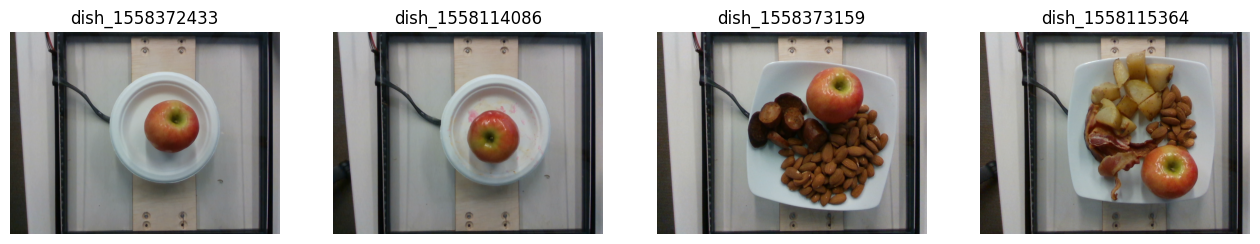


Images for deprecated id 458


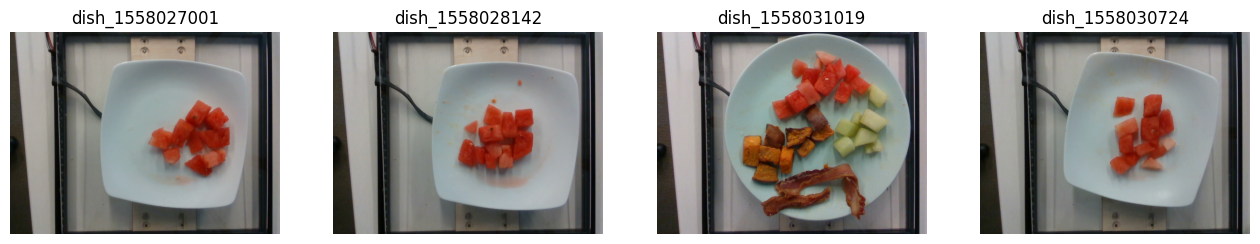


No dishes contain deprecated id 470


In [7]:
# Process deprecated ids
for depr_id in deprecated_ingr_ids:
    depr_dishes = dishes[dishes["ingredients"].str.contains(str(depr_id))]["dish_id"].to_list()
    if len(depr_dishes) != 0:
        print(f"Images for deprecated id {depr_id}")
        fig, ax = plt.subplots(
            1, len(depr_dishes[:4]), 
            figsize=(4*len(depr_dishes[:4]), 4))
        for i, dish_id in enumerate(depr_dishes[:4]):
            img = Image.open(f"data/images/{dish_id}/rgb.png")
            ax[i].imshow(img)
            ax[i].set_title(dish_id)
            ax[i].axis("off")
        plt.show()
        print()
    else:
        print(f"No dishes contain deprecated id {depr_id}")

It's save to assume that `id=453` is apple, and `id=458` is watermelon.

In [8]:
# Replace names
ingredients.loc[ingredients["id"]==453, "ingr"] = "apple"
ingredients.loc[ingredients["id"]==458, "ingr"] = "watermelon"

In [9]:
# Replace ingredient ids with names
id_to_name_dict = ingredients.set_index("id")["ingr"].to_dict()

def ingredient_id_to_name(ingredients_text):
    ingredient_list = ingredients_text.split(";")
    ingredient_ids_list = [int(i.lstrip("ingr_")) for i in ingredient_list]
    ingredient_names = [id_to_name_dict[ingr_id] for ingr_id in ingredient_ids_list]
    return ", ".join(ingredient_names)

dishes["ingredients"] = dishes["ingredients"].apply(ingredient_id_to_name)

In [10]:
# Rename columns
dishes.columns = ["image", "target", "total_mass", "text", "split"]

dishes.head()

,image,target,total_mass,text,split
0,dish_1561662216,300.794281,193.0,"soy sauce, garlic, white rice, parsley, onions...",test
1,dish_1561662054,419.438782,292.0,"pepper, white rice, mixed greens, garlic, soy ...",train
2,dish_1562008979,382.936646,290.0,"jalapenos, lemon juice, pork, wheat berry, cab...",test
3,dish_1560455030,20.590000,103.0,"cherry tomatoes, cucumbers, baby carrots",train
4,dish_1558372433,74.360001,143.0,apple,train


We have loaded the data and prepared it for modelling.

## 2. Exploratory Data Analysis

Now we will analyse the data:
- numeric features distributions
- correlation between `total_mass` and `target`

Statistics of the target feature
count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: target, dtype: float64


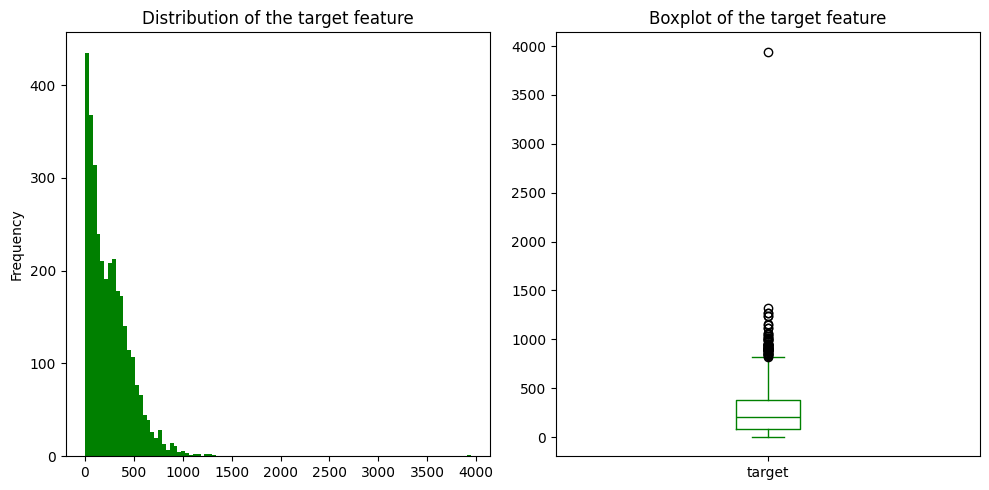

Statistics of the total_mass feature
count    3262.000000
mean      214.980074
std       161.497428
min         1.000000
25%        92.000000
50%       177.000000
75%       305.000000
max      3051.000000
Name: total_mass, dtype: float64


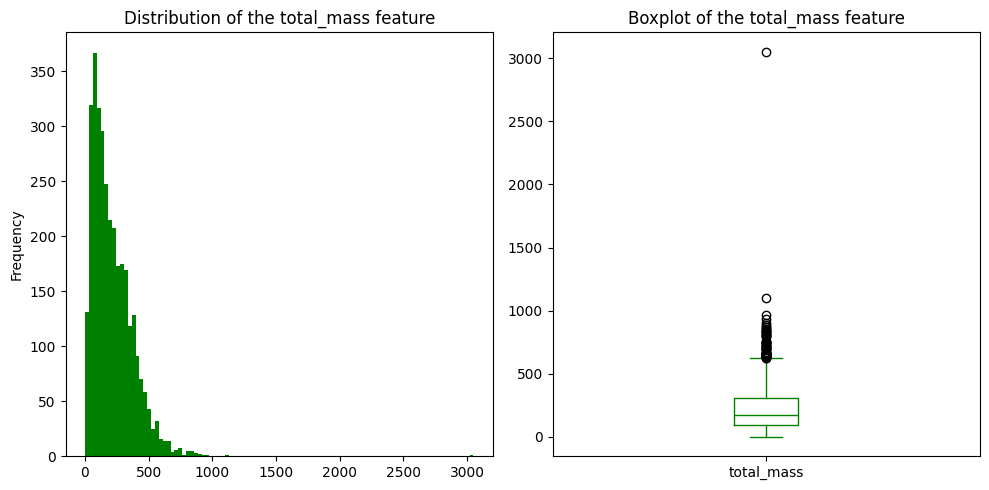

In [11]:
# Analyse numeric features
num_features = dishes.select_dtypes(exclude=["object"]).columns.to_list()

for f in num_features:
    print(f"Statistics of the {f} feature")
    print(dishes[f].describe())
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    dishes[f].plot(kind="hist", bins=100, ax=ax[0], color="green")
    dishes[f].plot(kind="box", ax=ax[1], color="green")
    ax[0].set_title(f"Distribution of the {f} feature")
    ax[1].set_title(f"Boxplot of the {f} feature")
    plt.tight_layout()
    plt.show()

In [12]:
# Check the outliers
outliers = dishes[dishes["target"] > 1500]
outliers

,image,target,total_mass,text,split
1518,dish_1560974769,3943.325195,3051.0,"spinach raw, tortilla chips, corn, cheese, wh...",train


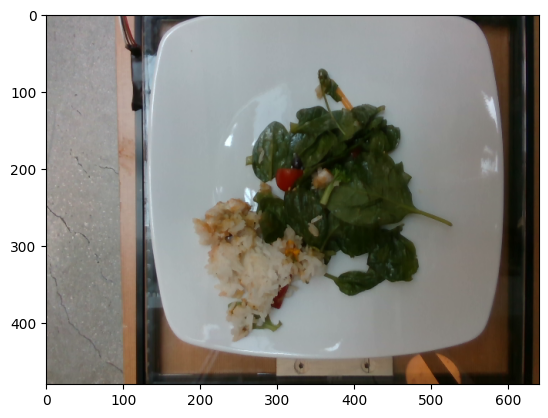

In [13]:
img = Image.open(f"data/images/dish_1560974769/rgb.png")
plt.imshow(img)

The outlier **belongs to the training data** and clearly looks like an error (mismatch between the image and the data). We can safely remove it from the dataset.

In [14]:
# Remove outlier
dishes = dishes.loc[dishes["target"] <= 1500]

Statistics of the target feature
count    3261.000000
mean      253.881701
std       209.955428
min         0.000000
25%        80.079994
50%       209.030762
75%       375.109985
max      1324.084961
Name: target, dtype: float64


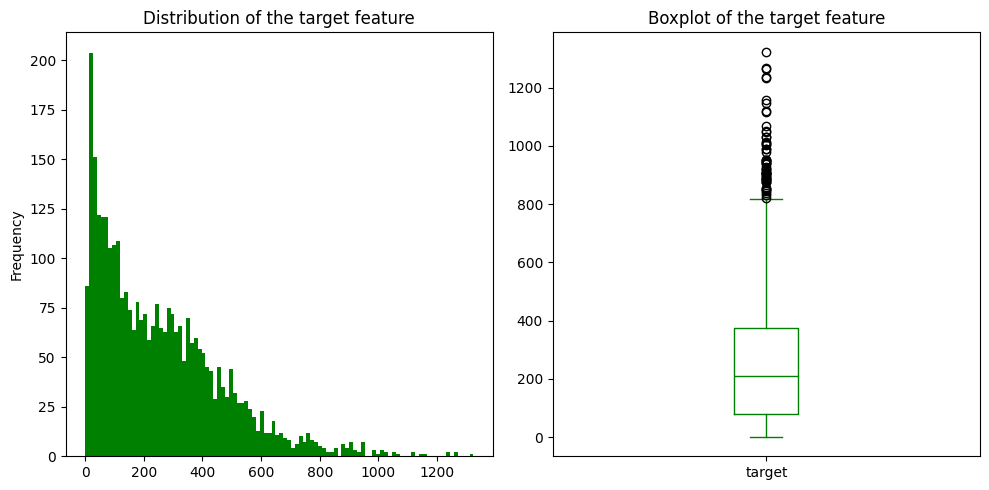

Statistics of the total_mass feature
count    3261.000000
mean      214.110396
std       153.692818
min         1.000000
25%        92.000000
50%       177.000000
75%       305.000000
max      1102.000000
Name: total_mass, dtype: float64


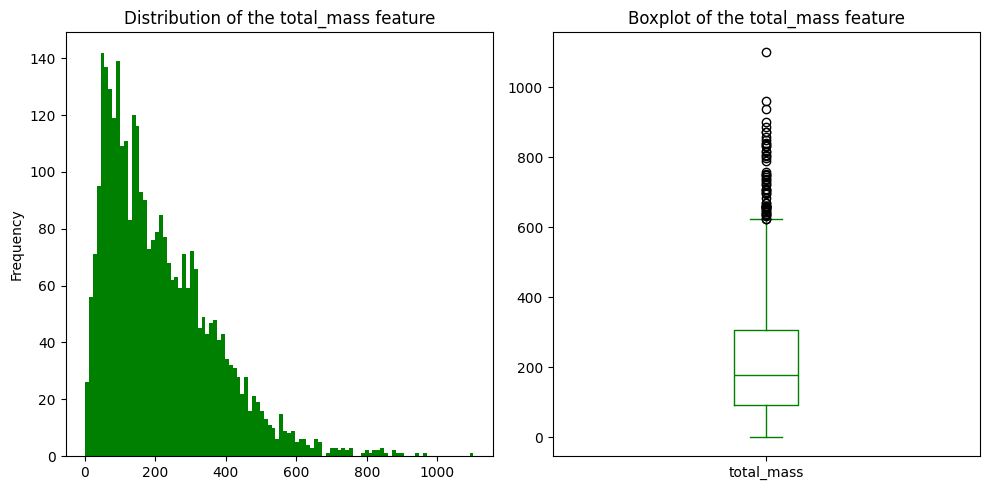

In [15]:
# Plot distributions after removing outliers
for f in num_features:
    print(f"Statistics of the {f} feature")
    print(dishes[f].describe())
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    dishes[f].plot(kind="hist", bins=100, ax=ax[0], color="green")
    dishes[f].plot(kind="box", ax=ax[1], color="green")
    ax[0].set_title(f"Distribution of the {f} feature")
    ax[1].set_title(f"Boxplot of the {f} feature")
    plt.tight_layout()
    plt.show()

In [16]:
# Calculate correlation coefficient
print(f'Correlation: {dishes["target"].corr(dishes["total_mass"]):.2f}')

Correlation: 0.74


Pretty high correlation means that the model will benefit a lot from the `total_mass` feature. As we don't want one feature to dominate over text and image embeddings, we will scale all the values based on the **training** dataset mean and std. We will save calculated values to the config for future experiments.

In [17]:
# Calculate mean and std of total_mass on train
mass_mean = dishes[dishes["split"]=="train"]["total_mass"].mean()
mass_std = dishes[dishes["split"]=="train"]["total_mass"].std()

print(f"Total Mass Mean (train): {mass_mean:.6f}")
print(f"Total Mass Std  (train): {mass_std:.6f}")

Total Mass Mean (train): 216.982571
Total Mass Std  (train): 153.920393


Now when we pass data into our model, we will scale it based on the training data.

## 3. Model Training

Before we train our model, we will split the data in 3: train data, validation data, and test data. Then we will create Dataset and DataLoader objects to pass into the model.

In [18]:
# Splitting train, val, test
dishes_train = dishes[dishes["split"]=="train"].reset_index(drop=True)
dishes_val_test = dishes[dishes["split"]=="test"].reset_index(drop=True)

dishes_val_test = shuffle(dishes_val_test, random_state=42).reset_index(drop=True)
split_idx = int(len(dishes_val_test) * 0.5)

dishes_val = dishes_val_test.iloc[:split_idx].reset_index(drop=True)
dishes_test = dishes_val_test.iloc[split_idx:].reset_index(drop=True)

print(f"Train Data: {len(dishes_train)} items.")
print(f"  Val Data:  {len(dishes_val)} items.")
print(f" Test Data:  {len(dishes_test)} items.")

# Save the datasets
dishes_train.to_csv(CONFIG.TRAIN_PATH, index=False)
dishes_val.to_csv(CONFIG.VAL_PATH, index=False)
dishes_test.to_csv(CONFIG.TEST_PATH, index=False)

Train Data: 2754 items.
  Val Data:  253 items.
 Test Data:  254 items.


In [19]:
# Create Dataloaders
train_data = create_dataloader(CONFIG, dishes_train, ds_type="train")
val_data = create_dataloader(CONFIG, dishes_val, ds_type="val")
test_data = create_dataloader(CONFIG, dishes_test, ds_type="val")

# Initialize the model
model = MultimodalModel(CONFIG)
model.to(DEVICE)
print(f"Model has been initialized.")

Model has been initialized.


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 1/20] train_loss: 152.53 | val_loss: 101.78


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 2/20] train_loss: 86.01 | val_loss: 90.48


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 3/20] train_loss: 80.30 | val_loss: 87.40


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 4/20] train_loss: 74.23 | val_loss: 76.32


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.69it/s]


[Epoch 5/20] train_loss: 73.05 | val_loss: 74.59


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 6/20] train_loss: 66.35 | val_loss: 67.59


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 7/20] train_loss: 63.63 | val_loss: 61.80


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s]


[Epoch 8/20] train_loss: 64.17 | val_loss: 62.89


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s]


[Epoch 9/20] train_loss: 61.38 | val_loss: 56.72


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s]


[Epoch 10/20] train_loss: 61.52 | val_loss: 60.49


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 11/20] train_loss: 59.06 | val_loss: 58.84


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s]


[Epoch 12/20] train_loss: 59.57 | val_loss: 59.38


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.62it/s]


[Epoch 13/20] train_loss: 54.99 | val_loss: 57.33


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.62it/s]


[Epoch 14/20] train_loss: 55.72 | val_loss: 51.06


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 15/20] train_loss: 57.25 | val_loss: 59.08


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 16/20] train_loss: 55.38 | val_loss: 55.54


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.58it/s]


[Epoch 17/20] train_loss: 54.47 | val_loss: 50.39


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s]


[Epoch 18/20] train_loss: 52.83 | val_loss: 55.53


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.63it/s]


[Epoch 19/20] train_loss: 53.56 | val_loss: 55.79


Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.63it/s]

[Epoch 20/20] train_loss: 51.20 | val_loss: 49.33


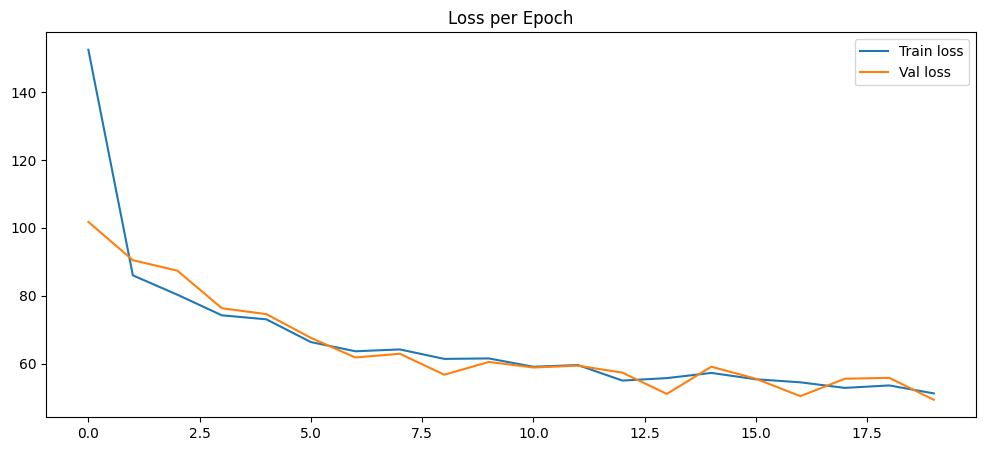

In [20]:
# Training and validation
train(model, CONFIG, train_data, val_data)

The model has achieved target quality of MAE less than 50.

## 4. Model Evaluation

Now we need to test in on unseen data to verify the quality.

In [21]:
# Testing model
test_mae, all_amages, all_texts, all_targets, all_predictions = validate(model, test_data)
print(f"MAE on test data = {test_mae:.2f}")

Validating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.62it/s]

MAE on test data = 49.87


The model shows the same quality on unseen data, which means that it learned to generalize rather than memorize the training data.

In [22]:
# Save model weights
os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), CONFIG.MODEL_PATH)
print(f"Model weights have been saved: {CONFIG.MODEL_PATH}")

Model weights have been saved: model/model.pt


Now we will analyse residuals to understand where the model makes the most mistakes.

In [23]:
# Create DF with residuals
residuals = pd.DataFrame({
    "image": all_amages, 
    "text": all_texts, 
    "true_calories": all_targets, 
    "pred_calories": all_predictions,
})
residuals["residual"] = residuals["true_calories"] - residuals["pred_calories"]
residuals.head()

,image,text,true_calories,pred_calories,residual
0,dish_1563984167,"egg whites, cantaloupe",291.679993,360.425385,-68.745392
1,dish_1561654374,"blackberries, mixed greens, raspberries, scram...",326.355530,279.701202,46.654327
2,dish_1565123783,cheese pizza,93.064995,97.746445,-4.681450
3,dish_1559578551,bacon,124.429993,128.557465,-4.127472
4,dish_1565118700,"chard, kale",16.660000,40.850052,-24.190052


Statistics of the Residuals
count    254.000000
mean      19.927116
std       78.306313
min     -214.988861
25%      -12.111446
50%        9.475470
75%       37.786011
max      422.438385
Name: residual, dtype: float64


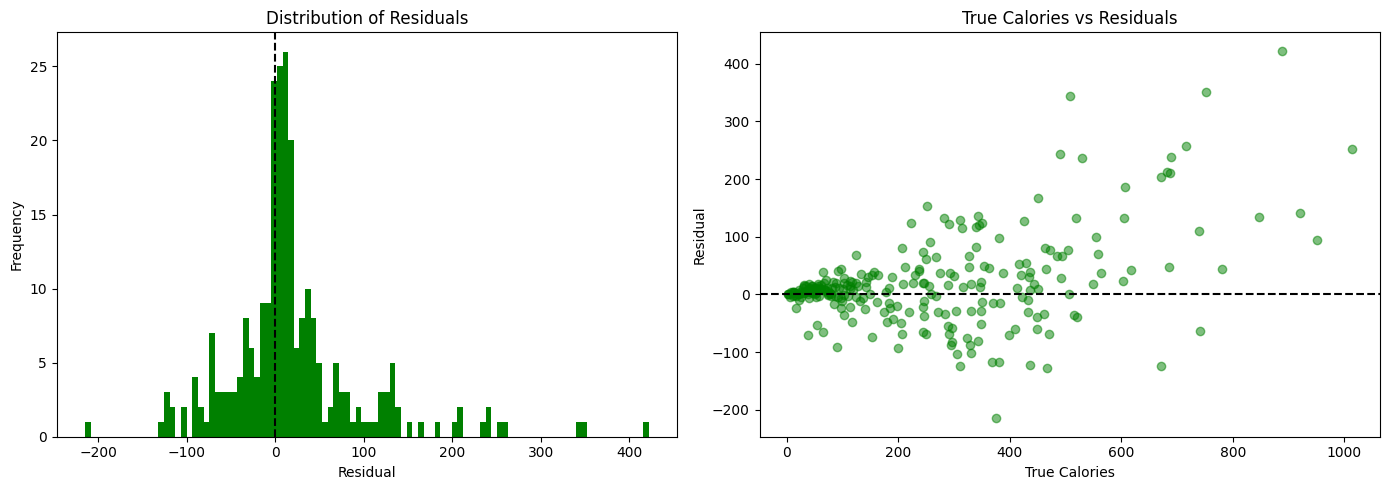

In [24]:
# Visualize residual analysis
print(f"Statistics of the Residuals")
print(residuals["residual"].describe())

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].hist(residuals["residual"], bins=100, color="green")
ax[0].axvline(0, color="black", linestyle="--")
ax[0].set_title("Distribution of Residuals")
ax[0].set_xlabel("Residual")
ax[0].set_ylabel("Frequency")

ax[1].scatter(
    residuals["true_calories"],
    residuals["residual"], 
    alpha=0.5, 
    color="green"
)
ax[1].axhline(0, color="black", linestyle="--")
ax[1].set_title("True Calories vs Residuals")
ax[1].set_xlabel("True Calories")
ax[1].set_ylabel("Residual")

plt.tight_layout()
plt.show()

Residuals are concentrated around 0, which is a good sign. The model makes most of its mistakes predicting hihg calorie dishes.

In [25]:
# Show top 5 wrong predictions
worst_predictions = residuals.sort_values(by="residual", ascending=False).head(5)
worst_predictions

,image,text,true_calories,pred_calories,residual
191,dish_1558720236,"apple, carrot, cauliflower, almonds",887.823059,465.384674,422.438385
110,dish_1558630325,"apple, garden salad, almonds",751.541992,400.407623,351.134369
84,dish_1566501594,brownies,508.048981,164.170624,343.878357
215,dish_1568401302,"fried rice, salt, squash, carrot, avocado, oli...",716.479370,459.257416,257.221954
204,dish_1558373159,"sausage, apple, almonds",1013.337036,761.529846,251.807190


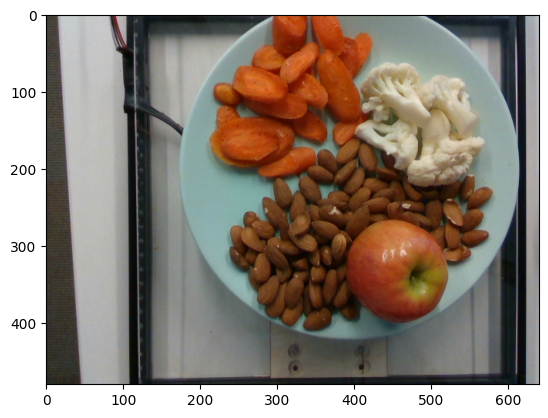

Description: apple, carrot, cauliflower, almonds
True: 887.82 | Predicted: 465.38



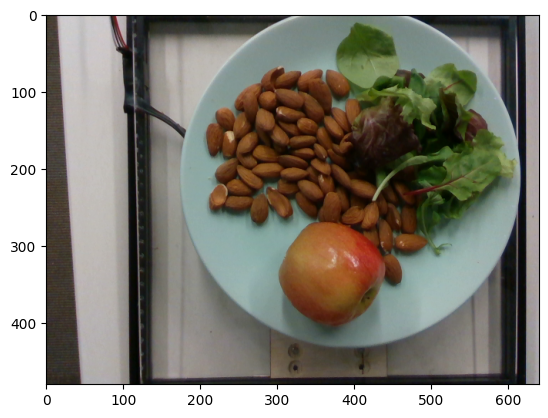

Description: apple, garden salad, almonds
True: 751.54 | Predicted: 400.41



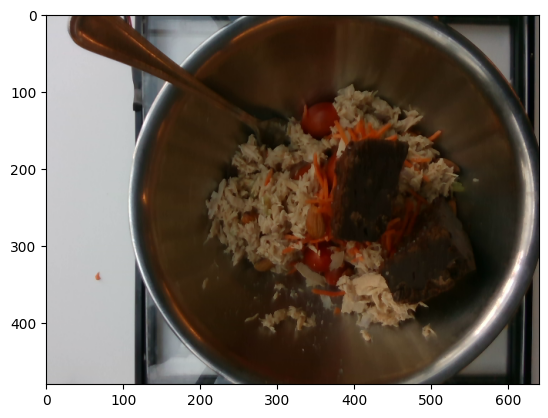

Description: brownies
True: 508.05 | Predicted: 164.17



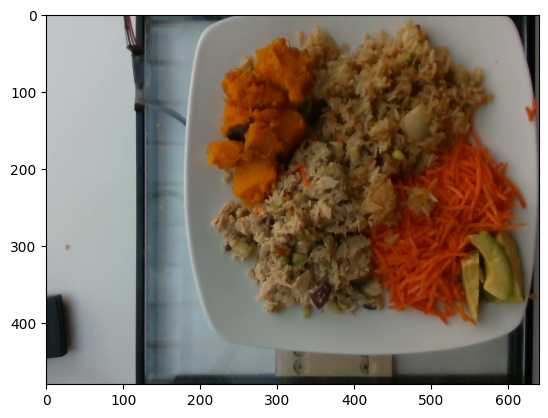

Description: fried rice, salt, squash, carrot, avocado, olive oil, tuna salad
True: 716.48 | Predicted: 459.26



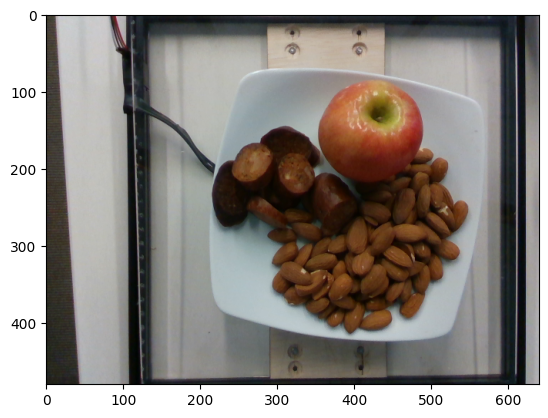

Description: sausage, apple, almonds
True: 1013.34 | Predicted: 761.53



In [26]:
# Show images and their description
def show_images_info(df_row):
    img = Image.open(f'data/images/{df_row["image"]}/rgb.png')
    plt.imshow(img)
    plt.show()
    print(f'Description: {df_row["text"]}')
    print(f'True: {df_row["true_calories"]:.2f} | Predicted: {df_row["pred_calories"]:.2f}\n')
    
for _, row in worst_predictions.iterrows():
    show_images_info(row)

* As we can see, most of the mistakes come from high-calorie nuts (almonds). Further model training with more examples can help with it.
* Another type of mistakes comes from the data mismatch: the 3rd image is missing ingredients in the text description. This means that we can improve our model by manual data integrity check.

## Conclusion

*Conclusion TBD*